In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from matplotlib.pyplot import cm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# Set GPU as the default device
tf.config.experimental.set_visible_devices(tf.config.experimental.list_physical_devices('GPU')[0], 'GPU')

# Verify that GPU is the default device
print("Default Device: ", tf.test.gpu_device_name())

Default Device:  /device:GPU:0


In [ ]:
!unzip drive/MyDrive/project2.zip

Archive:  drive/MyDrive/project2.zip
   creating: project2/
  inflating: project2/corridor_both_directions_revised.txt  
  inflating: project2/corridor_both_directions_revised_dataset.txt  
  inflating: project2/data_preprocessing.py  
  inflating: project2/left_turn_revised.txt  
  inflating: project2/left_turn_revised_dataset.txt  
  inflating: project2/supermarket_revised.txt  
  inflating: project2/supermarket_revised_dataset.txt  


In [ ]:
from creating_preprocessing_data import *

In [ ]:
!unzip drive/MyDrive/Pedestrian_Trajectories.zip

Archive:  drive/MyDrive/Pedestrian_Trajectories.zip
 extracting: Bottleneck_Data.zip     
 extracting: Corridor_Data.zip       


In [ ]:
!unzip ./Bottleneck_Data.zip

Archive:  ./Bottleneck_Data.zip
  inflating: uo-180-070.txt          
  inflating: uo-180-095.txt          
  inflating: uo-180-120.txt          
  inflating: uo-180-180.txt          


In [ ]:
bottleneck_data = create_dataset('uo-180-070.txt')

       timestep   ID         X        Y
0           218    1  1.297480  7.87177
1           219    1  1.307710  7.72562
2           220    1  1.325690  7.58186
3           221    1  1.346590  7.45493
4           222    1  1.348780  7.34659
...         ...  ...       ...      ...
70281      1813  141  0.421009 -5.80543
70282      1814  141  0.415451 -5.87892
70283      1815  141  0.414043 -5.94698
70284      1816  141  0.415002 -6.01000
70285      1817  141  0.418065 -6.07224

[75336 rows x 4 columns]


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


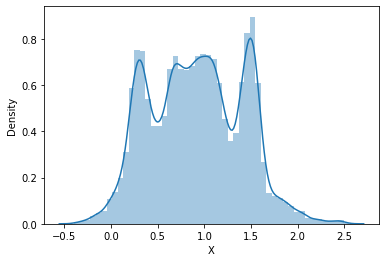

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


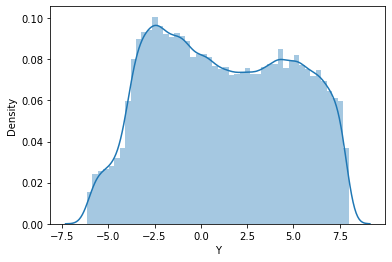

Number of data points:  75336


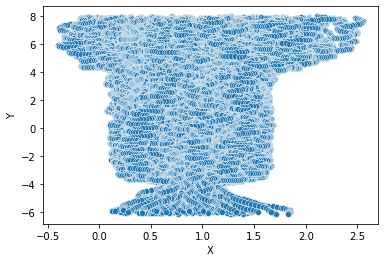

In [ ]:
sns.distplot(bottleneck_data['X'])
plt.show()
sns.distplot(bottleneck_data['Y'])
plt.show()

# Number of data points
print("Number of data points: ", bottleneck_data.shape[0])

# Presence of non-linear relationships
sns.scatterplot(x='X', y='Y', data=bottleneck_data)
plt.show()

Check if there are any NaN values

In [ ]:
bottleneck_data.lt(0).any().any()

True

In [ ]:
from preprocessing import *

In [ ]:
from scipy.spatial import distance 

In [ ]:
def remove_diagonal(A):
    return A[~np.eye(A.shape[0],dtype=bool)].reshape(A.shape[0],-1)

In [ ]:
NO_NEIGHBORS = 5
TIMESTEP_LENGTH = 0.4

dic = {
    'timestep': [],
    'pid': [],
    'pos': [],
    'mean_spacing': [],
    'speed': [],
    'knn': []
}

for timestep in range(1, bottleneck_data.timestep.max()):
    frame = bottleneck_data[bottleneck_data.timestep == timestep]
    next_frame = bottleneck_data[bottleneck_data.timestep == timestep + 1]

    frame = frame[frame['ID'].isin(next_frame['ID'])]
    next_frame = next_frame[next_frame['ID'].isin(frame['ID'])]

    if len(frame) <= NO_NEIGHBORS:
        continue

    pos = frame[['X', 'Y']].to_numpy()
    next_pos = next_frame[['X', 'Y']].to_numpy()

    dist = distance.squareform(distance.pdist(pos))
    dist = remove_diagonal(dist)[:, :NO_NEIGHBORS]

    knn = np.argsort(dist, axis=1)

    dic['timestep'] += frame.timestep.to_list()
    dic['pid'] += frame.ID.to_list()
    dic['pos'] += pos.tolist()
    dic['mean_spacing'] += dist.mean(axis = 1).tolist()
    dic['speed'] += (np.linalg.norm(next_pos - pos, axis=1) / TIMESTEP_LENGTH).tolist() 
    dic['knn'] += (pos[knn] - pos[:, np.newaxis]).tolist()

In [ ]:
bottleneck_temp = pd.DataFrame(dic)
# df2.to_csv('data/corridor_both_directions.csv', sep=' ', index=False)
bottleneck_temp

,timestep,pid,pos,mean_spacing,speed,knn
0,243,3,"[1.4946799999999998, 5.738379999999999]",1.519616,3.452938,"[[0.0, 0.0], [-0.41139999999999977, -0.9938599..."
1,243,1,"[1.08328, 4.74452]",1.861632,2.415851,"[[0.3532599999999999, 2.7334700000000005], [0...."
2,243,5,"[0.6019749999999999, 6.497240000000001]",1.460209,3.039082,"[[0.8927049999999999, -0.7588600000000012], [0..."
3,243,4,"[1.43654, 7.47799]",1.914890,3.385910,"[[-0.8227679999999999, -2.6315999999999997], [..."
4,243,2,"[0.613772, 4.84639]",1.832730,7.276876,"[[0.46950800000000004, -0.1018700000000008], [..."
...,...,...,...,...,...,...
74921,1748,141,"[0.68514, -3.15611]",1.475903,1.945160,"[[0.0, 0.0], [0.43898000000000004, -0.26461000..."
74922,1748,144,"[1.12412, -3.42072]",1.300942,0.071958,"[[-0.43898000000000004, 0.26461000000000023], ..."
74923,1748,138,"[0.745362, -3.9052100000000003]",1.059068,1.765289,"[[0.37875800000000004, 0.4844900000000001], [0..."
74924,1748,143,"[1.0961100000000001, -4.43774]",1.082957,3.332028,"[[-0.35074800000000017, 0.5325299999999995], [..."


In [ ]:
bottleneck_processed = convert_df(bottleneck_temp)
bottleneck_processed

,timestep,pid,speed,mean_spacing,ID,X,Y,0,1,2,3,4,5,6,7,8,9
0,243,3,3.452938,1.519616,3,1.494680,5.73838,0.000000,0.00000,-0.411400,-0.99386,-0.058140,1.73961,-0.892705,0.75886,-0.880908,-0.89199
1,243,1,2.415851,1.861632,1,1.083280,4.74452,0.353260,2.73347,0.411400,0.99386,0.000000,0.00000,-0.481305,1.75272,-0.469508,0.10187
2,243,5,3.039082,1.460209,5,0.601975,6.49724,0.892705,-0.75886,0.000000,0.00000,0.011797,-1.65085,0.834565,0.98075,0.481305,-1.75272
3,243,4,3.385910,1.914890,4,1.436540,7.47799,-0.822768,-2.63160,-0.834565,-0.98075,0.058140,-1.73961,-0.353260,-2.73347,0.000000,0.00000
4,243,2,7.276876,1.832730,2,0.613772,4.84639,0.469508,-0.10187,0.880908,0.89199,-0.011797,1.65085,0.822768,2.63160,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74921,1748,141,1.945160,1.475903,141,0.685140,-3.15611,0.000000,0.00000,0.438980,-0.26461,0.060222,-0.74910,0.410970,-1.28163,-0.393756,-2.78919
74922,1748,144,0.071958,1.300942,144,1.124120,-3.42072,-0.438980,0.26461,0.000000,0.00000,-0.378758,-0.48449,-0.028010,-1.01702,-0.832736,-2.52458
74923,1748,138,1.765289,1.059068,138,0.745362,-3.90521,0.378758,0.48449,0.000000,0.00000,-0.060222,0.74910,0.350748,-0.53253,-0.453978,-2.04009
74924,1748,143,3.332028,1.082957,143,1.096110,-4.43774,-0.350748,0.53253,0.000000,0.00000,0.028010,1.01702,-0.410970,1.28163,-0.804726,-1.50756


In [ ]:
print(bottleneck_processed.shape)

(74926, 17)


In [ ]:
bottleneck_processed.describe()

,timestep,pid,speed,mean_spacing,ID,X,Y,0,1,2,3,4,5,6,7,8,9
count,74926.000000,74926.000000,74926.000000,74926.000000,74926.000000,74926.000000,74926.000000,74926.000000,74926.000000,74926.000000,74926.000000,74926.000000,74926.000000,74926.000000,74926.000000,74926.000000,74926.000000
mean,918.995209,90.637963,9.640464,3.928815,90.637963,0.918786,1.249184,0.003354,0.087465,-0.002695,0.132664,-0.002460,0.122450,0.007418,0.033832,0.019981,-0.307542
std,344.711793,37.789647,6.980186,1.627751,37.789647,0.494908,3.618495,0.637242,1.829543,0.715828,2.922745,0.713554,4.178290,0.705993,5.552817,0.699935,7.123840
min,243.000000,1.000000,0.006042,0.612665,1.000000,-0.397188,-6.100250,-2.602141,-13.296500,-2.636549,-13.647460,-2.577879,-13.356980,-2.475306,-13.181020,-2.251302,-13.961910
25%,646.000000,63.000000,3.920769,2.759850,63.000000,0.522382,-1.853353,-0.442085,-0.810362,-0.513946,-1.846974,-0.503570,-3.114801,-0.492225,-4.708278,-0.473667,-6.776768
50%,904.000000,95.000000,7.888910,3.712506,95.000000,0.915977,1.081380,0.000000,0.003780,0.000000,0.014150,0.000000,0.000000,0.000000,0.000000,0.003325,-1.641167
75%,1172.000000,123.000000,14.172400,4.890284,123.000000,1.336085,4.366885,0.450060,0.907025,0.513242,2.013817,0.502798,3.256013,0.510327,4.738300,0.515897,6.415821
max,1748.000000,148.000000,34.755035,12.164057,148.000000,2.550470,7.969600,2.744269,13.298740,2.532480,12.787950,2.582167,13.961910,2.318788,13.714760,2.752387,13.784490


In [ ]:
print(bottleneck_processed.dtypes)

timestep          int64
pid               int64
speed           float64
mean_spacing    float64
ID                int64
X               float64
Y               float64
0               float64
1               float64
2               float64
3               float64
4               float64
5               float64
6               float64
7               float64
8               float64
9               float64
dtype: object


In [ ]:
X = bottleneck_processed[["timestep", "X", "Y", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "mean_spacing"]]
y = bottleneck_processed["speed"]

X

,timestep,X,Y,0,1,2,3,4,5,6,7,8,9,mean_spacing
0,243,1.494680,5.73838,0.000000,0.00000,-0.411400,-0.99386,-0.058140,1.73961,-0.892705,0.75886,-0.880908,-0.89199,1.519616
1,243,1.083280,4.74452,0.353260,2.73347,0.411400,0.99386,0.000000,0.00000,-0.481305,1.75272,-0.469508,0.10187,1.861632
2,243,0.601975,6.49724,0.892705,-0.75886,0.000000,0.00000,0.011797,-1.65085,0.834565,0.98075,0.481305,-1.75272,1.460209
3,243,1.436540,7.47799,-0.822768,-2.63160,-0.834565,-0.98075,0.058140,-1.73961,-0.353260,-2.73347,0.000000,0.00000,1.914890
4,243,0.613772,4.84639,0.469508,-0.10187,0.880908,0.89199,-0.011797,1.65085,0.822768,2.63160,0.000000,0.00000,1.832730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74921,1748,0.685140,-3.15611,0.000000,0.00000,0.438980,-0.26461,0.060222,-0.74910,0.410970,-1.28163,-0.393756,-2.78919,1.475903
74922,1748,1.124120,-3.42072,-0.438980,0.26461,0.000000,0.00000,-0.378758,-0.48449,-0.028010,-1.01702,-0.832736,-2.52458,1.300942
74923,1748,0.745362,-3.90521,0.378758,0.48449,0.000000,0.00000,-0.060222,0.74910,0.350748,-0.53253,-0.453978,-2.04009,1.059068
74924,1748,1.096110,-4.43774,-0.350748,0.53253,0.000000,0.00000,0.028010,1.01702,-0.410970,1.28163,-0.804726,-1.50756,1.082957


In [ ]:
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score ,KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

## Now we will run just a normal **Polynomial Regression** for the data and see how they compare (Benchmark)


Average MSE: 0.8340966145072015
Test MSE: 0.8274534915053996


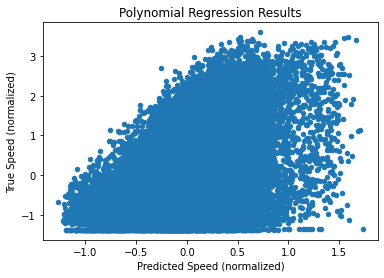

In [ ]:
# Split the data into features (X) and target (y)

X = bottleneck_processed[["timestep", "X", "Y", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "mean_spacing"]]
y = bottleneck_processed["speed"]

# Load the data
scaler_X = StandardScaler()

# Fit the scaler on X
scaler_X.fit(X)

# Transform X
X = scaler_X.transform(X)

# Initialize the scaler for y
scaler_y = StandardScaler()

# Fit the scaler on y
scaler_y.fit(y.values.reshape(-1, 1))

# Transform y
y = scaler_y.transform(y.values.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=101)

"""
# normalize the input (X) and output (y) separately using StandardScaler
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test = y_scaler.transform(y_test.reshape(-1, 1))
"""
# create a pipeline that combines normalization and regression
model = Pipeline([
  ('poly', PolynomialFeatures(degree=2)),
  ('regression', LinearRegression())
])

# use KFold cross-validation to evaluate the model
kfold = KFold(n_splits=5, shuffle=True, random_state=101)
scores = []
for train_index, val_index in kfold.split(X_train):
  X_train_fold, X_val = X_train[train_index], X_train[val_index]
  y_train_fold, y_val = y_train[train_index], y_train[val_index]

  # fit the model to the training data
  model.fit(X_train_fold, y_train_fold)

  # evaluate the model on the validation data
  y_val_pred = model.predict(X_val)
  score = mean_squared_error(y_val, y_val_pred)
  scores.append(score)

# print the average mean squared error across the 5 folds
print("Average MSE:", np.mean(scores))

# evaluate the model on the test data
y_test_pred = model.predict(X_test)
test_score = mean_squared_error(y_test, y_test_pred)
print("Test MSE:", test_score)

# plot the regression results
plt.scatter(y_test_pred, y_test, s=20)
plt.xlabel("Predicted Speed (normalized)")
plt.ylabel("True Speed (normalized)")
plt.title("Polynomial Regression Results")
plt.show()

## Now we run the Neural

In [35]:
# Create separate arrays for input (X) and output (y)
X = bottleneck_processed[["timestep", "X", "Y", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "mean_spacing"]]
y = bottleneck_processed["speed"]

# Load the data
scaler_X = StandardScaler()

# Fit the scaler on X
scaler_X.fit(X)

# Transform X
X = scaler_X.transform(X)

# Initialize the scaler for y
scaler_y = StandardScaler()

# Fit the scaler on y
scaler_y.fit(y.values.reshape(-1, 1))

# Transform y
y = scaler_y.transform(y.values.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
# Initialize a list to store the training, validation, and testing losses
training_losses = []
validation_losses = []
testing_losses = []

# Define the number of folds for the cross validation
n_folds = 5

# Initialize the KFold object for cross validation
kf = KFold(n_folds)

# Define the number of subsamples for the bootstrapping
n_subsamples = 50

# Loop over the subsamples
for i in range(n_subsamples):
    # Bootstrap the training data
    X_train_sub, y_train_sub = resample(X_train, y_train, random_state=i)
    
    # Loop over the folds for cross validation
    for train_index, val_index in kf.split(X_train_sub):
        X_train_cv, X_val = X_train_sub[train_index], X_train_sub[val_index]
        y_train_cv, y_val = y_train_sub[train_index], y_train_sub[val_index]
        
        # Build the model
        with tf.device('/GPU:0'):
          model = Sequential()
          model.add(Dense(units = 3, activation='relu', input_shape=(X_train_cv.shape[1],)))
          model.add(Dense(1))
          model.compile(optimizer='adam', loss='mean_squared_error')

        # Add Early stopping in case the model overfits
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
        
        # Train the model on the training data
        with tf.device('/GPU:0'):
          history = model.fit(X_train_cv, y_train_cv, epochs=100, verbose=1,validation_data=(X_val, y_val), callbacks=[early_stopping])
    
        # Evaluate the model on the validation data
        with tf.device('/GPU:0'):
          val_loss = model.evaluate(X_val, y_val, verbose=1)
          validation_losses.append(val_loss)
        
        # Evaluate the model on the testing data
        with tf.device('/GPU:0'):
          test_loss = model.evaluate(X_test, y_test, verbose=1)
          testing_losses.append(test_loss)
#Calculate the mean and standard deviation of the training loss

mean_training_loss = np.mean(history.history['loss'])
std_training_loss = np.std(history.history['loss'])
training_losses.append((mean_training_loss, std_training_loss))

#Calculate the mean and standard deviation of the validation losses

mean_validation_loss = np.mean(validation_losses)
std_validation_loss = np.std(validation_losses)

#Calculate the mean and standard deviation of the testing losses
mean_testing_loss = np.mean(testing_losses)
std_testing_loss = np.std(testing_losses)

print("Mean training loss: {:.4f} +/- {:.4f}".format(mean_training_loss, std_training_loss))
print("Mean validation loss: {:.4f} +/- {:.4f}".format(mean_validation_loss, std_validation_loss))
print("Mean testing loss: {:.4f} +/- {:.4f}".format(mean_testing_loss, std_testing_loss))

Streaming output truncated to the last 5000 lines.
937/937 [==============================] - 2s 2ms/step - loss: 0.8956 - val_loss: 0.8760
Epoch 5/100
937/937 [==============================] - 2s 2ms/step - loss: 0.8927 - val_loss: 0.8735
Epoch 6/100
937/937 [==============================] - 2s 2ms/step - loss: 0.8905 - val_loss: 0.8706
Epoch 7/100
937/937 [==============================] - 3s 3ms/step - loss: 0.8887 - val_loss: 0.8679
Epoch 8/100
937/937 [==============================] - 2s 2ms/step - loss: 0.8868 - val_loss: 0.8666
Epoch 9/100
937/937 [==============================] - 2s 3ms/step - loss: 0.8855 - val_loss: 0.8659
Epoch 10/100
937/937 [==============================] - 2s 2ms/step - loss: 0.8841 - val_loss: 0.8673
Epoch 11/100
937/937 [==============================] - 2s 3ms/step - loss: 0.8837 - val_loss: 0.8629
Epoch 12/100
937/937 [==============================] - 3s 3ms/step - loss: 0.8822 - val_loss: 0.8614
Epoch 13/100
937/937 [===========================

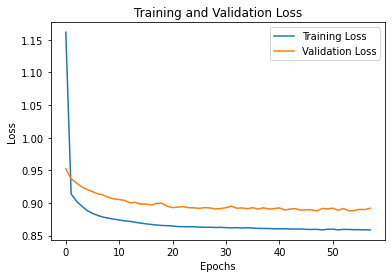

1171/1171 [==============================] - 2s 1ms/step


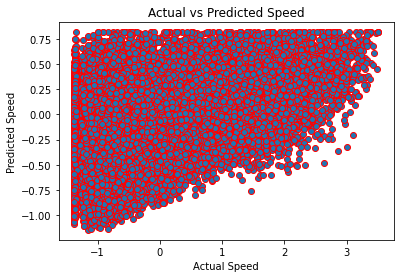

1171/1171 [==============================] - 2s 1ms/step


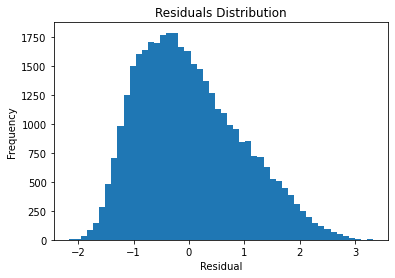

In [37]:

# Plot the training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()



# Plot the actual vs predicted speeds
plt.scatter(y_test, model.predict(X_test), edgecolors='r')
plt.xlabel('Actual Speed')
plt.ylabel('Predicted Speed')
plt.title('Actual vs Predicted Speed')
plt.show()

# Plot the residuals
residuals = y_test - model.predict(X_test)
plt.hist(residuals, bins=50)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()
